In [1]:
import warnings
from sys import stdout
import sys

import numpy as np
import pandas as pd
import pylab as plot

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import  SVR
from sklearn import metrics
from IPython.display import display

from module_utils.utils import head_shape, describe_plus, na_per_col, total_na_df, highlight_bests_metrics, train_test_df
from module_utils.scoreRegression import onehot_encoder
from module_utils.model_training import plot_mae_and_predict, train_model, compute_losses_reg, training_models
from module_utils.preprocess import extract_x_y
sns.set(font_scale=1.2, style="darkgrid", palette="colorblind", color_codes=True)
params = {"legend.fontsize":15,
          "legend.handlelength":2}
plot.rcParams.update(params)
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
df = pd.read_csv('../All Data (human readable column names).csv', sep = ',')

In [3]:
# drop useless columns
drop_id = ['ID', 'Surface Scan Device ID', 'Juice Scan Device ID']
df = df.drop(drop_id, axis=1)

# targets columns
target_variables = df.filter(regex="Brix|Antioxidants|Polyphenols", axis=1).columns

# Juice scans columns
juice_col = df.filter(regex="Juice", axis=1).columns
juice_target = df.filter(regex="Juice|Antioxidants|Polyphenols|Brix", axis=1).columns

# Surface scans columns
df.rename(columns={"Surface Scan 386nm":"Surface Scan 385nm"}, inplace=True)
surface_col = df.loc[:, df.columns.str.startswith("Surface")].columns
surface_target = df.filter(regex="Surface|Antioxidants|Polyphenols|Brix", axis=1).columns

# Juice and surface scans columns
surface_juice_col = surface_col.append(juice_col)
surface_juice_target = surface_juice_col.append(target_variables)

In [4]:
df_type_poly_surface = df.filter(regex="Surface|Brix|Polyphenols|Antioxidants|Type").dropna()

In [5]:
head_shape(df_type_poly_surface)

,Type,Brix,Polyphenols,Antioxidants,Surface Scan 365nm,Surface Scan 385nm,Surface Scan 450nm,Surface Scan 500nm,Surface Scan 530nm,Surface Scan 587nm,Surface Scan 632nm,Surface Scan 850nm,Surface Scan 880nm,Surface Scan 940nm
18,kale,8.8,124.78,17453.50,1.4300,2.2310,7.5800,6.155,12.670,12.22,7.848,56.35,64.74,61.15
19,kale,5.5,132.01,18693.60,2.0200,3.4970,9.9600,8.341,14.350,15.76,10.720,55.02,61.58,68.33
20,kale,6.0,90.50,11900.40,0.6584,0.6085,5.1970,7.758,12.540,13.75,9.819,58.43,69.38,57.07
24,carrot,7.5,4.33,93.73,1.5400,0.9140,-0.4908,2.843,6.821,47.94,49.480,58.75,73.09,49.70
25,carrot,7.4,3.56,107.07,0.6809,-0.2204,-1.0710,2.328,6.156,43.87,44.060,53.59,68.12,44.78


(1291, 14)

In [6]:
index_df = df_type_poly_surface.index
columns_types = np.sort(df_type_poly_surface['Type'].unique())
values = np.array(df_type_poly_surface[['Type']])
vegetables = df['Type'].dropna().unique()

In [7]:
df_type = onehot_encoder(values, index_df, columns_types)
df_ohe = pd.concat([df_type_poly_surface, df_type], axis=1).drop("Type", axis=1)

In [8]:
head_shape(df_ohe)

,Brix,Polyphenols,Antioxidants,Surface Scan 365nm,Surface Scan 385nm,Surface Scan 450nm,Surface Scan 500nm,Surface Scan 530nm,Surface Scan 587nm,Surface Scan 632nm,Surface Scan 850nm,Surface Scan 880nm,Surface Scan 940nm,carrot,cherry_tomato,grape,kale,lettuce,other,spinach
18,8.8,124.78,17453.50,1.4300,2.2310,7.5800,6.155,12.670,12.22,7.848,56.35,64.74,61.15,0,0,0,1,0,0,0
19,5.5,132.01,18693.60,2.0200,3.4970,9.9600,8.341,14.350,15.76,10.720,55.02,61.58,68.33,0,0,0,1,0,0,0
20,6.0,90.50,11900.40,0.6584,0.6085,5.1970,7.758,12.540,13.75,9.819,58.43,69.38,57.07,0,0,0,1,0,0,0
24,7.5,4.33,93.73,1.5400,0.9140,-0.4908,2.843,6.821,47.94,49.480,58.75,73.09,49.70,1,0,0,0,0,0,0
25,7.4,3.56,107.07,0.6809,-0.2204,-1.0710,2.328,6.156,43.87,44.060,53.59,68.12,44.78,1,0,0,0,0,0,0


(1291, 20)

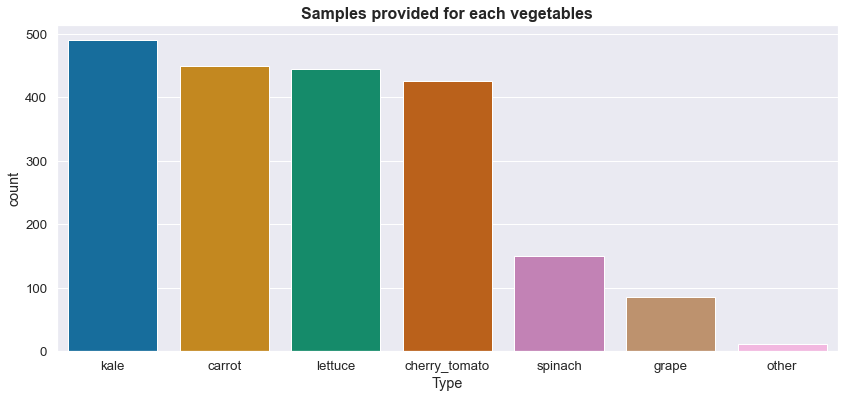

In [9]:
plt.figure(figsize=(14,6))
sns.countplot(x="Type", data=df, order=df['Type'].value_counts().index)
plt.title("Samples provided for each vegetables", fontsize=16, weight="bold")
plt.show()

In [10]:
# init model objects
lin_regression = LinearRegression()
pls = PLSRegression(n_components=5)
svr_rbf = SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1, coef0=1)
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
models_list = [lin_regression, pls, svr_rbf, rf_regressor]
# create list of models used for training - for columns name
models_name = ['Linear regression', 'Partial least squares', 'SVR RBF', 'RF regressor']

- #### Columns: Surface Scans
- #### Type: All
- #### Target: Brix

In [11]:
x, y = extract_x_y(df=df_ohe, target=target_variables, col_index=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [12]:
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (903, 17)
x_test (388, 17)
y_train (903,)
y_test (388,)


In [13]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.471412,1.498926,0.179920,0.533170
MSE,4.216917,4.387726,0.306738,0.557176
R2,0.697505,0.685252,0.977997,0.960032
RMSE,2.053513,2.094690,0.553839,0.746442
Score Classifier,0.817276,0.820598,0.986711,0.932447


In [14]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.179920,0.146983
MSE,0.306738,0.148896
R2,0.977997,0.986419
RMSE,0.553839,0.385870
Score Classifier,0.986711,0.994845


- #### Columns: Surface Scans
- #### Type: All
- #### Target: Polyphenols

In [15]:
x, y = extract_x_y(df=df_ohe, target=target_variables, col_index=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [16]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,60.640944,58.150633,86.371985,19.437562
MSE,11847.171994,12273.083345,31803.120606,1550.354663
R2,0.587935,0.573121,-0.106167,0.946076
RMSE,108.844715,110.783949,178.334295,39.374543
Score Classifier,0.757475,0.753045,0.985604,0.946844


In [17]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,19.437562,21.289381
MSE,1550.354663,2015.954052
R2,0.946076,0.922984
RMSE,39.374543,44.899377
Score Classifier,0.946844,0.925258


- #### Columns: Surface Scans
- #### Type: All
- #### Target: Antioxidants

In [18]:
x, y = extract_x_y(df=df_ohe, target=target_variables, col_index=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [19]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1975.468808,1897.960610,2443.885614,669.209503
MSE,14493820.338247,14782347.122866,31081240.145181,2064345.200318
R2,0.464785,0.454130,-0.147741,0.923770
RMSE,3807.075037,3844.781804,5575.055170,1436.782934
Score Classifier,0.847176,0.853821,0.992248,0.945736


In [20]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,669.209503,507.158500
MSE,2064345.200318,1375212.304778
R2,0.923770,0.918453
RMSE,1436.782934,1172.694464
Score Classifier,0.945736,0.951031


## MSE of target variables per vegetables

In [50]:
def mse_per_vegetables(df, vegetables, model, col_index=0):
    vegetable_dict = dict()
    for veg in vegetables:
        x = df[df[veg]==1].iloc[:,3:].values
        y = df[df[veg]==1].iloc[:,col_index].values

        y_pred = model.predict(x)
        vegetable_dict[veg] = metrics.mean_squared_error(y, y_pred)
    return vegetable_dict

In [51]:
mse_per_veg_df = pd.DataFrame.from_dict(mse_per_vegetables(df=df_ohe, vegetables=vegetables,model=svr_rbf, col_index=0), orient="index")
mse_per_veg_df.columns=["MSE"]
mse_per_veg_df.plot(kind="bar", figsize=(14,6))
plt.xlabel('Vegetables', fontsize=14)
plt.ylabel('Brix', fontsize=14)
plt.title('MSE of Brix per vegetables with SVR RBF', fontsize=16, fontweight="bold")
plt.show()

ValueError: X.shape[1] = 17 should be equal to 11, the number of features at training time

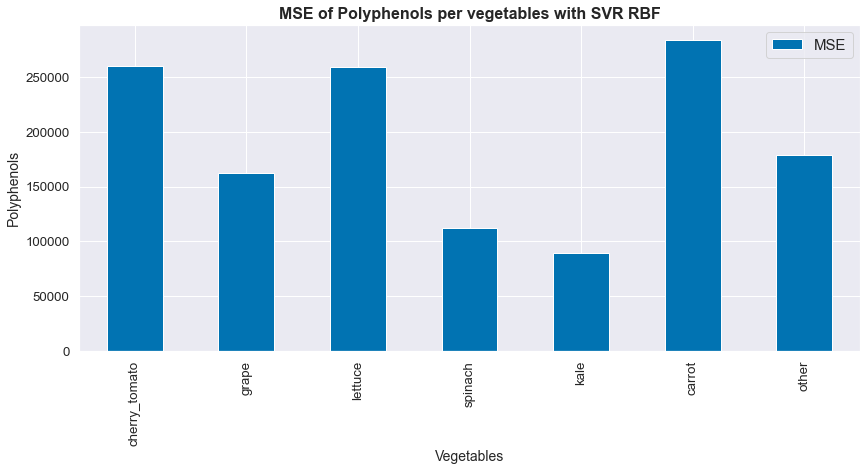

In [23]:
mse_per_veg_df = pd.DataFrame.from_dict(mse_per_vegetables(df=df_ohe, vegetables=vegetables,model=svr_rbf, col_index=1), orient="index")
mse_per_veg_df.columns=["MSE"]
mse_per_veg_df.plot(kind="bar", figsize=(14,6))
plt.xlabel('Vegetables', fontsize=14)
plt.ylabel('Polyphenols', fontsize=14)
plt.title('MSE of Polyphenols per vegetables with SVR RBF', fontsize=16, fontweight="bold")
plt.show()

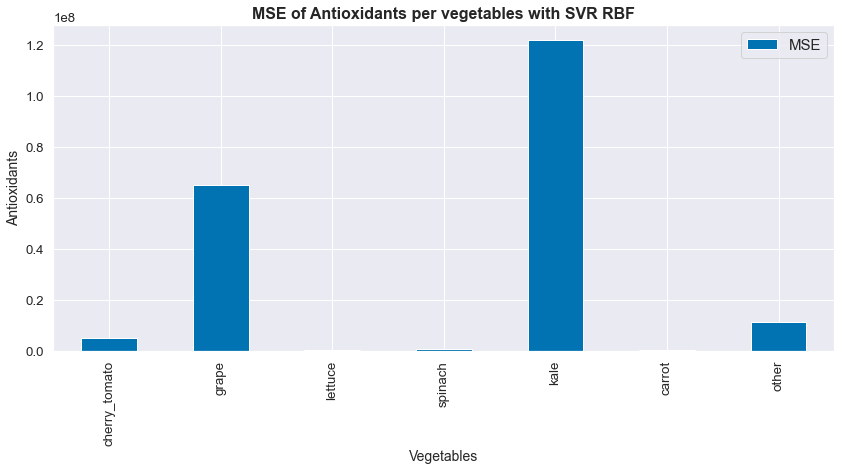

In [24]:
mse_per_veg_df = pd.DataFrame.from_dict(mse_per_vegetables(df=df_ohe, vegetables=vegetables,model=svr_rbf, col_index=2), orient="index")
mse_per_veg_df.columns=["MSE"]
mse_per_veg_df.plot(kind="bar", figsize=(14,6))
plt.xlabel('Vegetables', fontsize=14)
plt.ylabel('Antioxidants', fontsize=14)
plt.title('MSE of Antioxidants per vegetables with SVR RBF', fontsize=16, fontweight="bold")
plt.show()

## Distribution of the target variables per vegetable

In [25]:
def test_dist_func(df, vegetables, target, title, xlabel, ylabel, figsize=(14,6)):
    fig = plt.figure(figsize=figsize)
    for veg in vegetables:
        sns.displot(df[df['Type']==veg][target].dropna(), hist=True, kde=False, bins=35, label=veg)
        plt.title(title, fontsize=16, fontweight="bold")
        plt.xlabel(target, fontsize=14)
        plt.ylabel("Counts", fontsize=14)
        plt.legend()

In [26]:
#test_dist_func(df=df, vegetables=vegetables, target="Polyphenols", title="", xlabel="", ylabel="")

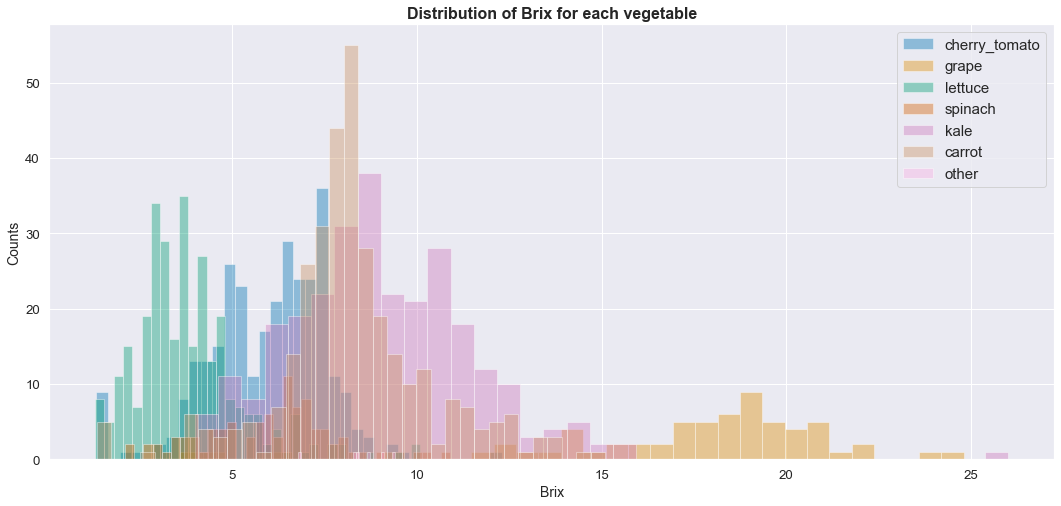

In [27]:
plt.figure(figsize=(18,8))
for veg in vegetables:
    sns.distplot(df[df["Type"]==veg]["Brix"].dropna(), hist=True, kde=False, bins=35, label=veg)
    plt.title("Distribution of Brix for each vegetable", fontsize=16, fontweight="bold")
    plt.xlabel("Brix", fontsize=14)
    plt.ylabel("Counts", fontsize=14)
    plt.legend()

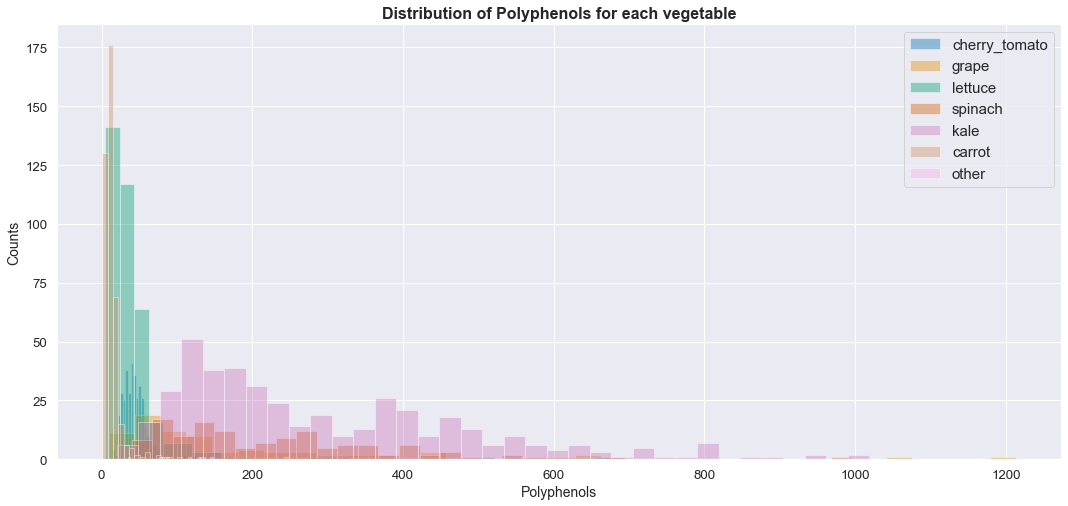

In [28]:
plt.figure(figsize=(18,8))
for veg in vegetables:
    sns.distplot(df[df["Type"]==veg]["Polyphenols"].dropna(), hist=True, kde=False, bins=35, label=veg)
    plt.title("Distribution of Polyphenols for each vegetable", fontsize=16, fontweight="bold")
    plt.xlabel("Polyphenols", fontsize=14)
    plt.ylabel("Counts", fontsize=14)
    plt.legend()

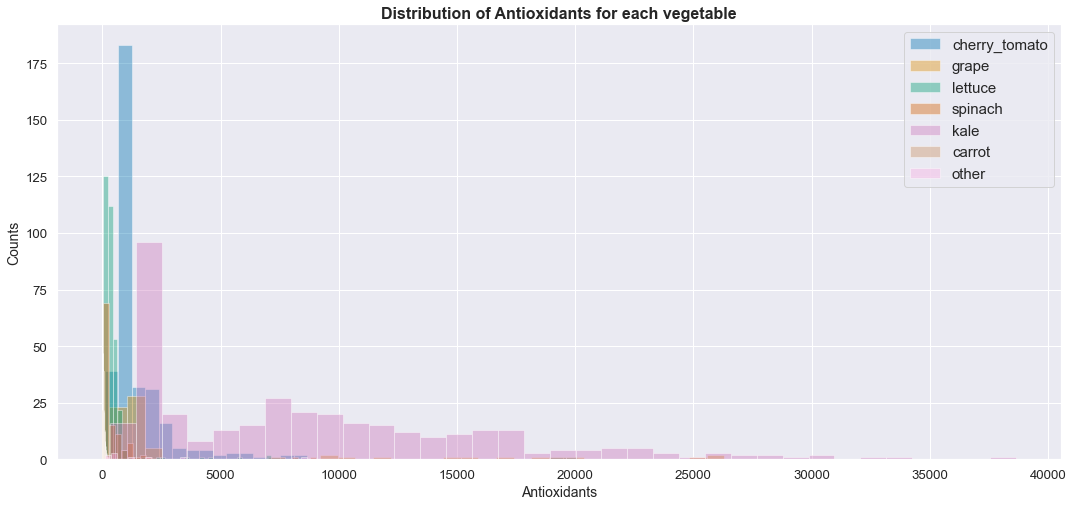

In [29]:
plt.figure(figsize=(18,8))
for veg in vegetables:
    sns.distplot(df[df["Type"]==veg]["Antioxidants"].dropna(), hist=True, kde=False, bins=35, label=veg)
    plt.title("Distribution of Antioxidants for each vegetable", fontsize=16, fontweight="bold")
    plt.xlabel("Antioxidants", fontsize=14)
    plt.ylabel("Counts", fontsize=14)
    plt.legend()

## TEST

- #### Columns: Surface Scans
- #### Type: Kale
- #### Target: Brix

In [30]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|kale", axis=1), target=target_variables, col_index=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [31]:
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (903, 11)
x_test (388, 11)
y_train (903,)
y_test (388,)


In [32]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,2.193768,2.184827,0.183259,0.619283
MSE,9.401707,9.874291,0.330728,0.789618
R2,0.325580,0.291680,0.976276,0.943358
RMSE,3.066220,3.142338,0.575089,0.888604
Score Classifier,0.740864,0.751938,0.986711,0.922481


In [33]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.183259,0.147691
MSE,0.330728,0.152187
R2,0.976276,0.986119
RMSE,0.575089,0.390112
Score Classifier,0.986711,0.992268


- #### Target: Polyphenols

In [34]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|kale", axis=1), target=target_variables, col_index=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [35]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,73.766891,72.240680,87.893462,22.267220
MSE,14338.131370,14718.322638,32346.753817,1758.831649
R2,0.501295,0.488072,-0.125076,0.938825
RMSE,119.741937,121.319094,179.852033,41.938427
Score Classifier,0.674419,0.719823,0.996678,0.899225


In [36]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,22.267220,24.851020
MSE,1758.831649,2430.345430
R2,0.938825,0.907153
RMSE,41.938427,49.298534
Score Classifier,0.899225,0.889175


- #### Target: Antioxidants

In [37]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|kale", axis=1), target=target_variables, col_index=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [38]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1973.161058,1903.584667,2445.292948,667.199768
MSE,14977097.611180,15084255.641178,31090143.184273,2055437.461806
R2,0.446939,0.442982,-0.148070,0.924099
RMSE,3870.025531,3883.845471,5575.853583,1433.679693
Score Classifier,0.830565,0.841639,0.996678,0.943522


In [39]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,667.199768,503.315792
MSE,2055437.461806,1364688.075063
R2,0.924099,0.919077
RMSE,1433.679693,1168.198645
Score Classifier,0.943522,0.958763


- #### Columns: Surface Scans
- #### Type: Lettuce
- #### Target: Brix

In [40]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|lettuce", axis=1), target=target_variables, col_index=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [41]:
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (903, 11)
x_test (388, 11)
y_train (903,)
y_test (388,)


In [42]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,2.111353,2.130917,0.183373,0.601184
MSE,8.892455,9.374936,0.330943,0.776296
R2,0.362111,0.327500,0.976260,0.944313
RMSE,2.982022,3.061852,0.575276,0.881077
Score Classifier,0.710963,0.718715,0.990033,0.928018


In [43]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.183373,0.147696
MSE,0.330943,0.152288
R2,0.976260,0.986110
RMSE,0.575276,0.390241
Score Classifier,0.990033,0.994845


- #### Target: Polyphenols

In [44]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|lettuce", axis=1), target=target_variables, col_index=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [45]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,76.201293,74.480157,87.863511,21.621480
MSE,14638.671447,15546.175379,32335.495874,1835.350114
R2,0.490842,0.459277,-0.124684,0.936163
RMSE,120.990377,124.684303,179.820733,42.840986
Score Classifier,0.665559,0.719823,0.996678,0.924695


In [46]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,21.621480,24.907061
MSE,1835.350114,2411.647171
R2,0.936163,0.907867
RMSE,42.840986,49.108524
Score Classifier,0.924695,0.871134


- #### Target: Antioxidants

In [47]:
x, y = extract_x_y(df=df_ohe.filter(regex="Brix|Polyphenols|Antioxidants|Surface|lettuce", axis=1), target=target_variables, col_index=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [48]:
train_df = training_models(x=x_train, y=y_train, models=models_list, col_name=models_name)
test_df = training_models(x=x_test, y=y_test, models=models_list, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,2649.988475,2637.844887,2445.306573,794.689964
MSE,19956636.719696,20234429.047796,31090465.416353,2496319.955839
R2,0.263059,0.252801,-0.148082,0.907818
RMSE,4467.285162,4498.269561,5575.882479,1579.974669
Score Classifier,0.717608,0.730897,0.996678,0.887043


In [49]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,794.689964,702.846698
MSE,2496319.955839,1829674.725595
R2,0.907818,0.891504
RMSE,1579.974669,1352.654696
Score Classifier,0.887043,0.824742
